*Nguồn tham khảo:* [Tejas Jain](https://deepnote.com/@tj/The-Starry-Cat-7HRaWnp8QhWYeK_x_QLD9Q)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
import numpy as np

import torch
from torch import optim
from torchvision import transforms, models

In [ ]:
vgg = models.vgg19(pretrained=True)
vgg_features = vgg.features

# Turn off gradient update
for param in vgg_features.parameters():
    param.requires_grad = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_features.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def fetch_img(path, shape=None, size=400, debug=False):
    """
    Function to load in an image and transform it to a tensor
    
    Args:
        path: path of the input image
        shape: explicit shape (if needed)
        size: set the size of image tensor
        debug: If true, display image

    Returns:
        image tensor on available device
    """

    img = mpimg.imread(path)

    if debug:
        plt.imshow(img)

    if max(img.shape) < size:
        size = max(img.size)

    # if an explicit shape is passed, then override size to that shape
    if shape:
        size = shape

    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize(size), transforms.ToTensor(), 
                                    transforms.Normalize((0.485, 0.456, 0.406), 
                                                        (0.229, 0.224, 0.225))])
    # unsqueeze(0) adds a batch dimension
    img_tensor = transform(img)[:3,:,:].unsqueeze(0)
    return img_tensor.to(device)

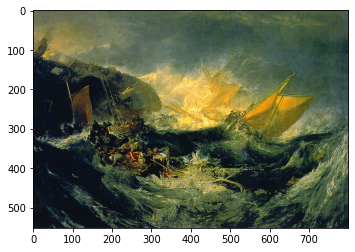

In [ ]:
style_path = "/content/drive/MyDrive/seminar_ml_data/the_shipwreck_of_the_minotaur.jpg" # specify the path of your own style image
style_tensor = fetch_img(style_path, debug=True)

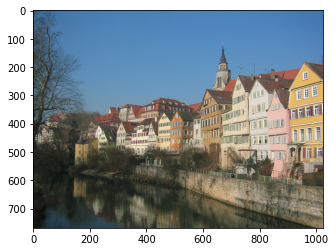

In [ ]:
content_path = "/content/drive/MyDrive/seminar_ml_data/tubingen.jpg" # specify the path of the image on which you want to perform style transfer
content_tensor = fetch_img(content_path, shape=style_tensor.shape[-2:], debug=True)

In [ ]:
def fetch_conv_feat(model, img, layers=None):

    conv_features = {}

    # if layers are not provided, use default layers (based on StyleGAN paper)
    if not layers:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

    for name, layer in model._modules.items():
        img = layer(img)
        if name in layers:
            conv_features[layers[name]] = img

    return conv_features

In [ ]:
def tensor_to_img(tensor):
    """
    Convert the input tensor back to image

    Args: 
        tensor: input image tensor

    Returns:
        image in numpy array
    """

    tensor = tensor.squeeze().permute(1, 2, 0)  # remove batch dim and swap axes for numpy
    tensor = tensor.to("cpu").clone().detach()  # move tensor to cpu 
    img = tensor.numpy()
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # undo normalisation
    img = img.clip(0, 1)

    return img

In [ ]:
def gram_matrix(tensor):
    
    batch_size, depth, height, width = tensor.size()
    
    # flatten the spatial data
    tensor = tensor.view(depth, height * width)

    gram_mat = torch.mm(tensor, tensor.t())
    
    return gram_mat 

In [ ]:
style_features = fetch_conv_feat(vgg_features, style_tensor)
content_features = fetch_conv_feat(vgg_features, content_tensor)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a clone of the transfer image tensor
# this tensor will be changed iteratively 
target_tensor = content_tensor.clone().requires_grad_(True).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
style_weights = {'conv1_1': 0.2,
                 'conv2_1': 0.2,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

In [ ]:
# define an alpha (content_weight) and a beta (style_weight) based on the StyleGAN paper
content_weight = 1  # alpha
style_weight = 1e3  # beta

In [ ]:
display_rate = 400

optimizer = optim.Adam([target_tensor], lr=0.001)
steps = 16000

for idx in range(1, steps + 1):
    
    # fetch features from target image
    target_features = fetch_conv_feat(vgg_features, target_tensor)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0

    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        batch_size, depth, height, width = target_feature.shape

        style_gram = style_grams[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        style_loss += layer_style_loss / (depth * height * width)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # print loss and display intermediate images
    if  idx % display_rate == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(tensor_to_img(target_tensor))
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

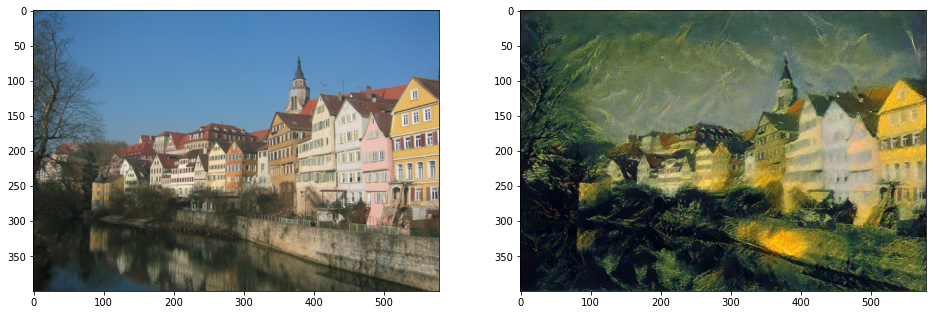

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
ax1.imshow(tensor_to_img(content_tensor))
ax2.imshow(tensor_to_img(target_tensor))